# ch17_10 torch dataloader

이번 챕터에서는 본격적으로 딥러닝 모델링에 들어가기 앞서서, torch에서 딥러닝 모델 학습을 위해 대량의 데이터 셋을 처리하는 기법에 대해서 알아보겠습니다.

지금까지는 모든 데이터 셋이 메모리에 한번에 올라올 수 있는 사이즈가 작은 데이터 셋들이었습니다. 그런데 몇만장의 이미지로 구성된 데이터 셋은 어떨까요? 혹은 수십GB에 달하는 텍스트 데이터라면 어떨까요? 이들을 한번에 메모리에 올리기 보단, 일정한 단위로 메모리에 올려서 모델 학습을 진행하고, 다시 다음 단위를 메모리에 올리는 것이 좋겠죠? torch에서 이런 기능을 제공해주는 기능이 dataset과 dataloader입니다.

데이터 셋 링크: https://www.kaggle.com/datasets/tongpython/cat-and-dog  
참고 자료: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

## 데이터 셋 폴더 구조

실습을 위해 사용할 데이터 셋은 강아지와 고양이 이미지 데이터 셋입니다. 폴더 구조는 아래와 같습니다. 먼저 train과 test로 나뉜 뒤, 그 아래에 고양이 이미지와 강아지 이미지들을 담은 폴더가 위치합니다. 그리고 labels에는 각 이미지 파일 경로와 라벨이 담겨있습니다. 라벨은 고양이는 0, 강아지는 1입니다.

```
cats_and_dogs
├── test
│   ├── cats
│   ├── dogs
│   └── label.csv
└── train
    ├── cats
    ├── dogs
    └── label.csv
```

## Dataset

### CustomDataset 정의
torch에서 데이터 셋을 다루려면 먼저 Dataset 클래스를 상속 받은 Custom Dataset이 있어야 합니다. Custom Dataset은 데이터 샘플 하나를 어떻게 읽어와서 어떻게 처리할 지를 정의하는 클래스입니다.

In [52]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(f"{img_dir}/label.csv")
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}"
        img = read_image(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.img_labels.iloc[idx, 1]
        return img, label 

In [43]:
dataset = CustomImageDataset(img_dir="./data/cats_and_dogs/train")

In [44]:
len(dataset)

8000

In [40]:
img_tensor, label = dataset[1]

실제로 이미지를 잘 읽어왔는지 플랏을 그려보겠습니다.

In [108]:
from matplotlib import pyplot as plt

def plot_img_tensor(img_tensor, cmap=None):
    img_array = img_tensor.numpy()
    img_array = img_array.transpose(1, 2, 0)
    plt.imshow(img_array, cmap=cmap)

### transform

현재는 입력 이미지의 크기가 제각각입니다. 이 경우, 모델의 구조와 학습 방법이 상당히 까다로워집니다. 때문에 입력으로 들어오는 이미지의 크기를 고정하는 전처리를 취해주겠습니다. 

먼저 가로, 세로 중 더 짧은 쪽의 크기를 256으로 조정하겠습니다. 그 다음, 중심을 기준으로 (256, 256) 크기로 크롭해주겠습니다.

In [45]:
from torchvision.transforms import transforms, Resize, CenterCrop

desired_size = 256
transform = transforms.Compose([
    Resize(size=desired_size),
    CenterCrop(desired_size)
])

In [53]:
dataset = CustomImageDataset(img_dir="./data/cats_and_dogs/train", transform=transform)

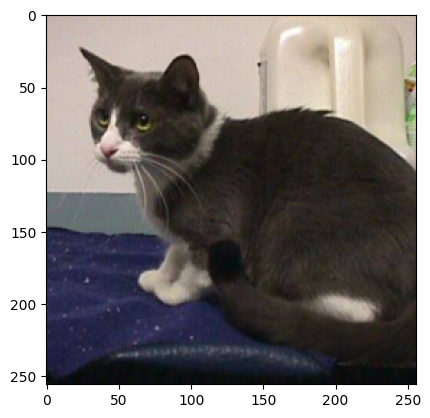

In [58]:
plot_img_tensor(dataset[3][0])

### data augmentation

In [90]:
from torchvision.transforms import transforms, Resize, RandomCrop, RandomHorizontalFlip, RandomRotation

desired_size = 256
transform = transforms.Compose([
    Resize(size=desired_size),
    RandomCrop(size=desired_size),
    RandomHorizontalFlip(),
    RandomRotation(degrees=(-45, 45))
])

In [91]:
dataset = CustomImageDataset(img_dir="./data/cats_and_dogs/train", transform=transform)

/Users/user/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


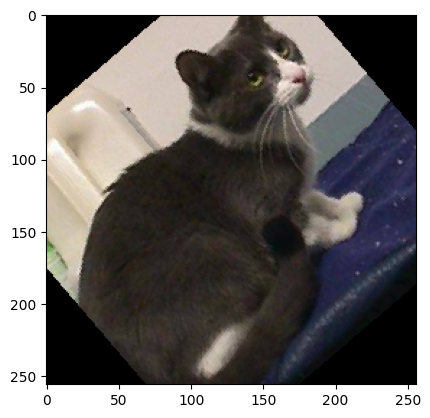

In [92]:
plot_img_tensor(dataset[3][0])

## DataLoader

전체 데이터 셋은 고양이 4000장, 강아지 4000장으로 구성되어 있습니다. 하지만 이를 한꺼번에 메모리에 올려서 모델을 학습시키는 것은 메모리와 CPU, GPU에 엄청난 부담이 갑니다. 때문에 일정한 크기로 데이터 셋을 불러와서 모델을 학습시켜야 합니다. 여기서 일정한 크기를 배치라고 부르고, 데이터를 배치 단위로 읽어오는 역할은 DataLoader가 수행합니다.

dataloader를 만들어보고, batch로 불러온 이미지 텐서를 시각화 해보겠습니다.

In [93]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [95]:
for batch in dataloader:
    img_batch_tensor, label_batch_tensor = batch
    print(img_batch_tensor.shape)
    break

torch.Size([8, 3, 256, 256])


시각화를 해보면 개와 고양이가 잘 섞여서 불러와 지는 것을 확인할 수 있습니다.

In [96]:
def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0]
    label_batch = batch[1]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[label_batch[i].item()]}")

In [97]:
cat_dog_label_dict = {0: "cat", 1: "dog"}

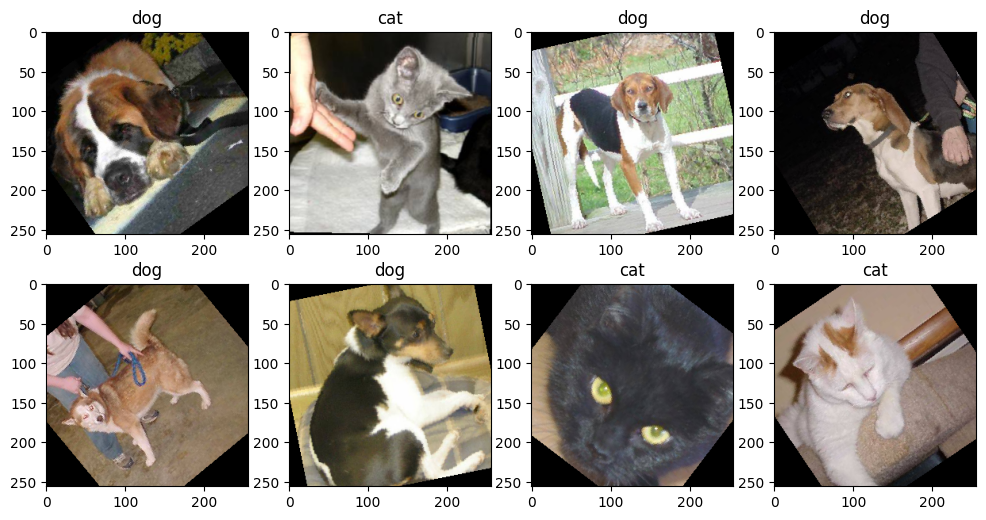

In [102]:
for batch in dataloader:
    plot_batch(batch, cat_dog_label_dict)
    break

## Load Dataset

이렇게 직접 수집한 데이터 셋으로 torch Dataset과 Dataloader를 만들어서 사용할 수도 있지만, 이미 만들어져 있는 데이터 셋을 그대로 불러와서 사용할 수도 있습니다. 딥러닝 입문 시에 가장 많이 사용되는 MINIST 데이터 셋을 한번 로딩해보겠습니다.

### MNIST dataset

MNIST dataset은 0부터 9 사이 숫자들의 손글씨 이미지를 모아놓은 데이터 셋입니다.

In [103]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [107]:
train_dataset[2][0].shape

torch.Size([1, 28, 28])

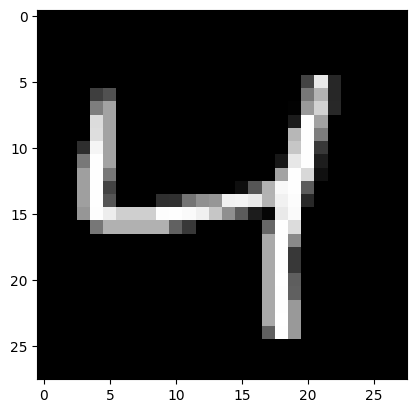

In [111]:
plot_img_tensor(train_dataset[2][0], cmap="gray") 

이렇게 불러온 데이터 셋을 데이터 로더로 만들어서 사용합니다.

In [112]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [113]:
mnist_label_dict = {x: x for x in range(10)}

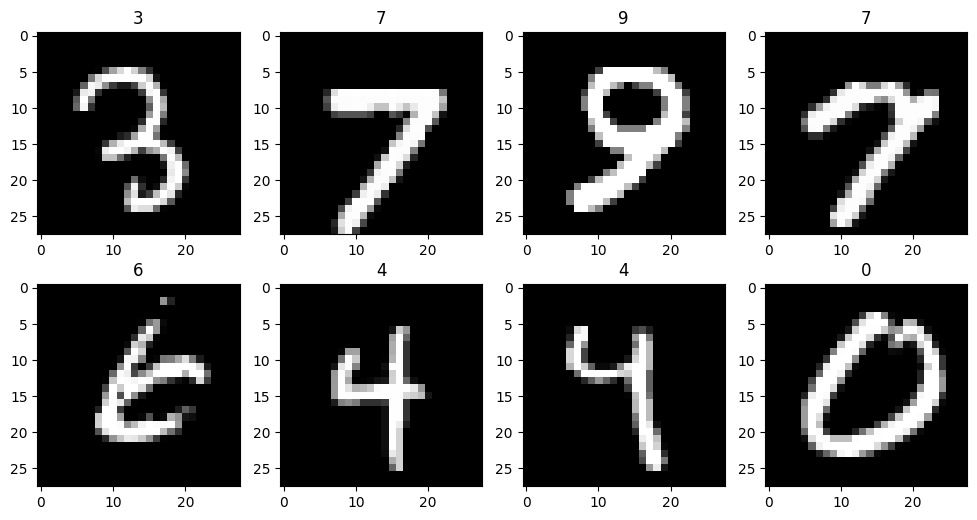

In [115]:
for batch in train_dataloader:
    plot_batch(batch, mnist_label_dict, cmap="gray")
    break

## 정리

이번 챕터에서는 torch dataset과 dataloader를 다루는 법에 대해서 알아보았습니다. 그리고 데이터 셋에 무작위 적으로 조작을 가해, 데이터 셋의 크기를 부풀리는 data augmentation 기법에 대해서 알아보았습니다. 다음 챕터에서는 본격적으로 딥러닝 모델을 이용하여 이미지 분류 모델을 학습시켜 보겠습니다. 